In [106]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

# Import required libraries
#import sklearn
import numpy as np
import matplotlib.pyplot as plt

# Dividing dataset into training and testing dataset and standarized the features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import SGDClassifier

from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler


In [107]:
periodo = 365
USE_CUMSUM = True

zona_norte_grande = """(1,2,3)"""
zona_norte_chico = """(4,5)"""
zona_nucleo_central = """(6,7,8,9,10,11,12,13,14,15,16,17)"""
zona_concepcion_frontera = """(18,19,20,21,28,29)"""
zona_region_de_los_lagos = """(22,23,24)"""
zona_region_canales = """(25,26,33)"""



grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
lista_zonas = ["ZonaNorteGrande",
               "ZonaNorteChico",
               "ZonaNucleoCentral",
               "ZonaConcepcionLaFrontera",
               "ZonaRegionDeLosLagos",
               "ZonaRegionCanales"]
#targets_establecimientos = ["CEAR", "SAPU", "SUR", "SAR", "Hospital"]
lista_establecimientos = ["Hospital",  "SAPU","SAR", "SUR","CEAR"]
#lista_establecimientos = ["Hospital",  "SAPU","SAR"]
#lista_establecimientos = ["SAPU", "SAR","Hospital"]
lista_establecimientos_legend = ["Hospital",  "SAPU","SAR", "SUR","CEAR"]
#lista_establecimientos_legend = ["Hospital",  "SAPU","SAR"]
grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]



In [108]:
#lista de todos los tipo de establecimientos
duckdb.sql("""select distinct GLOSATIPOESTABLECIMIENTO from datos_urgencia_consolidados.parquet""").show(max_rows = 100)
# CEAR: Exclusivos de Atención Respiratoria (CEAR). Pocos datos, sin información para todos los dias
# SUR: Servicio de Urgencia Rural. Pocos datos, sin información para todos los dias
# SAR: Servicio de Atención Primaria de Urgencias de Alta Resolución
# SAPU: Servicio de Atención Primaria de Urgencias

┌──────────────────────────┐
│ GLOSATIPOESTABLECIMIENTO │
│         varchar          │
├──────────────────────────┤
│ SAR                      │
│ SAPU                     │
│ SUR                      │
│ Hospital                 │
│ CEAR                     │
└──────────────────────────┘



(0.0, 0.8)

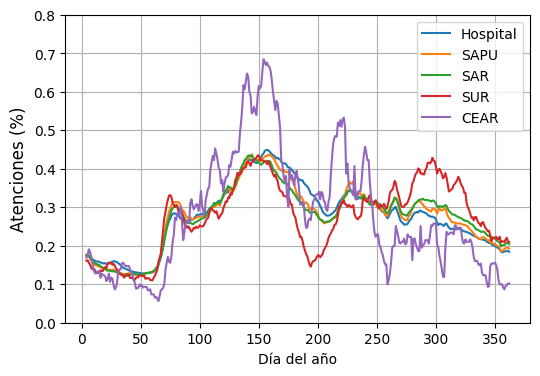

In [110]:
#simple plot of the data
df_agrupado_establecimiento = duckdb.sql("""
select GLOSATIPOESTABLECIMIENTO as establecimiento
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Total) as atenciones
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
and CodigoDependencia is not null
and GLOSATIPOESTABLECIMIENTO is not null
and CodigoDependencia in (9,10,11,12,13,14)
group by  GLOSATIPOESTABLECIMIENTO, nrodia
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
order by establecimiento, nrodia
""").df()
df = df_agrupado_establecimiento
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for establecimiento in lista_establecimientos:
    for column in ['atenciones']:
        filtro_filas = (df["establecimiento"]== establecimiento)
        plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
        #plt.plot(df.loc[filtro_filas,'nrodia'],df.loc[filtro_filas,column].rolling(7,center=True).mean()) # c = color)
#plt.legend(targets)
plt.legend(lista_establecimientos)
ax.grid()
#ax.set_title('Hospitalizaciones diarias por causa respiratoria\n población pediátrica año ' + year_figure +'. Media móvil a 7 días, \nlos datos son escalados por total de Hospitalizaciones.', fontsize = 10)
#ax.set_title('Año ' + year_figure, fontsize = 12,loc='left')
ax.set_xlabel('Día del año', fontsize = 10)
ax.set_ylabel('Atenciones (%)', fontsize = 12)
#ax.set_ylabel('Cantidad hospitalizaciones', fontsize = 12)
ax.set_ylim(ymin=0)
ax.set_ylim(ymax=0.8)

In [111]:
#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoDependencia
    , GLOSATIPOESTABLECIMIENTO as establecimiento
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
and CodigoDependencia is not null
and GLOSATIPOESTABLECIMIENTO is not null
and CodigoDependencia in (9,10,11,12,13,14)
group by CodigoDependencia, GLOSATIPOESTABLECIMIENTO, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
""").df()

df2 = df2.sort_values(by=['CodigoDependencia','establecimiento','year','nrodia']).reset_index(drop = True)
df3 = pd.concat([df2[['CodigoDependencia','establecimiento',"year","nrodia","Menores_1"]].rename(columns={"Menores_1":"atenciones"}).assign(grupo_etario = "Menores_1"),
df2[['CodigoDependencia','establecimiento',"year","nrodia","De_1_a_4"]].rename(columns={"De_1_a_4":"atenciones"}).assign(grupo_etario = "De_1_a_4"),
df2[['CodigoDependencia','establecimiento',"year","nrodia","De_5_a_14"]].rename(columns={"De_5_a_14":"atenciones"}).assign(grupo_etario = "De_5_a_14"),
df2[['CodigoDependencia','establecimiento',"year","nrodia","De_15_a_64"]].rename(columns={"De_15_a_64":"atenciones"}).assign(grupo_etario = "De_15_a_64"),
df2[['CodigoDependencia','establecimiento',"year","nrodia","De_65_y_mas"]].rename(columns={"De_65_y_mas":"atenciones"}).assign(grupo_etario = "De_65_y_mas")
])

df2 = df3.sort_values(by=["year",'CodigoDependencia','establecimiento',"grupo_etario","nrodia"]).reset_index(drop=True)

#with pd.option_context('display.max_rows', None,):
#    display(df2[['year','CodigoDependencia','establecimiento','grupo_etario']].drop_duplicates())

In [112]:
display(df2["establecimiento"].drop_duplicates())

0         Hospital
1825          SAPU
3650           SAR
96710          SUR
111310        CEAR
Name: establecimiento, dtype: object

In [113]:
# Hay entradas correspondientes a centros de salud rurales 
# en que no hay datos para todos los dias del año, por lo 
# cual trabajaremos bajo la suposicion que corresponden a 
# cero atenciones para aquellos días

lista_dias = [k+1 for k in range(periodo)]

groups = df2[['year','CodigoDependencia','establecimiento','grupo_etario']].drop_duplicates()
df_aux =df2.copy()
df_output_list = []
for (index, year, codigo_dependencia, establecimiento, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoDependencia'] == codigo_dependencia) & (df_aux.loc[:,'establecimiento'] == establecimiento) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if sum(indicesToKeep) <365:
            df_fill_data = df_aux.loc[indicesToKeep, :].set_index("nrodia").reindex(lista_dias).reset_index()
            df_fill_data.loc[:,"year"] = year
            df_fill_data.loc[:,"CodigoDependencia"] = codigo_dependencia
            df_fill_data.loc[:,"establecimiento"] = establecimiento
            df_fill_data.loc[:,"grupo_etario"] = grupo_edad
            df_output_list.append(df_fill_data.fillna(0))
        else: 
            df_output_list.append(df_aux.loc[indicesToKeep, :])

df_output = pd.concat(df_output_list).reset_index(drop = True)
df_output = df_output.sort_values(by=["year",'CodigoDependencia','establecimiento',"grupo_etario","nrodia"]).reset_index(drop=True)
#print(df_output.drop_duplicates().shape[0])


In [114]:
#the cumulative sum is taken on each of the classes, 

groups = df_output[["year",'CodigoDependencia','establecimiento',"grupo_etario"]].drop_duplicates()
df_aux =df_output.copy()
for (index, year, codigo_dependencia, establecimiento, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoDependencia'] == codigo_dependencia) & (df_aux.loc[:,'establecimiento'] == establecimiento) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if USE_CUMSUM:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / max(df_aux.loc[indicesToKeep, 'atenciones'])
        else:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / sum(df_aux.loc[indicesToKeep, 'atenciones'])
df3 = df_aux.pivot(index=['year','CodigoDependencia','establecimiento','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()
df3_copy = df3.copy()
#df3_aux = df3_copy[~df3_copy["CodigoDependencia"].isna()]
#df3_aux = df3_aux[~df3_aux["establecimiento"].isna()]
#print(df3_copy.shape[0])
#df3_aux = df3_copy.copy()
#for k in range(364):
#    df3_aux = df3_aux[~df3_aux[k+1].isna()]
#print(df3_aux.shape[0])

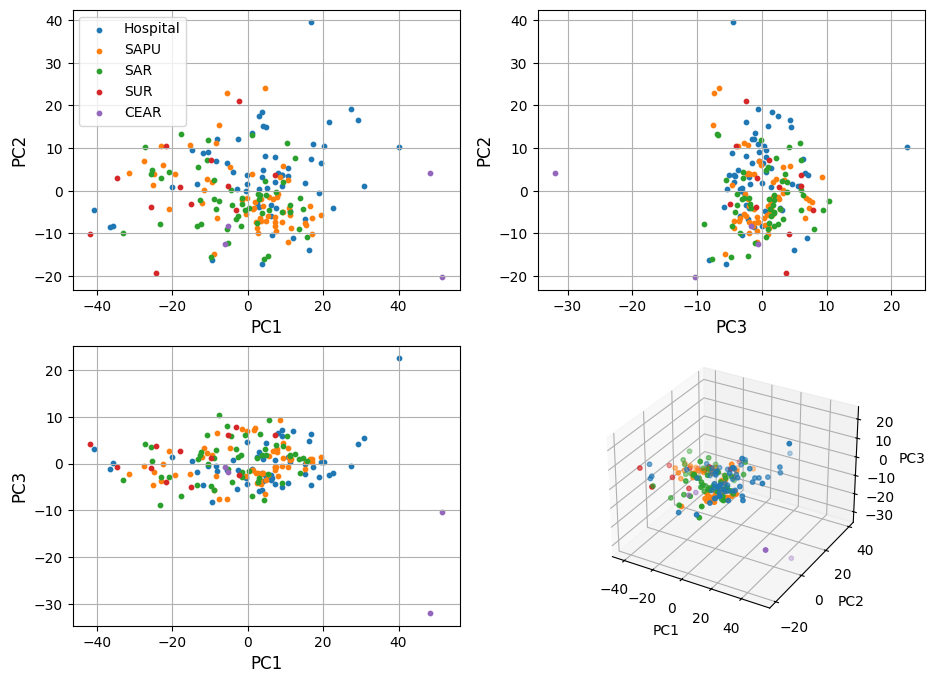

In [115]:
df3 = df3_copy

#indica cuales son los grupos etarios que vamos a unir para la clasificacion
row_filter = []
#for ind in [0,1,2]:  #pacientes pediatricos
for ind in [3,4]:  #pacientes no pediatricos
    if len(row_filter) == 0:
        row_filter = (df3.loc[:,"grupo_etario"]==grupos_etarios[ind])
    else:
        row_filter = row_filter | (df3.loc[:,"grupo_etario"]==grupos_etarios[ind])

df3 = df3.loc[row_filter,:].reset_index(drop=True)

# Separating out the features
x_original = df3.loc[:, [k+1 for k in range(periodo)]].values

# Separating out the target
y = df3.loc[:,['establecimiento']].values

#Standardizing the features
scaler = StandardScaler().fit(x_original)
x = scaler.transform(x_original)

pca = PCA(n_components=4)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4'])
finalDf = pd.concat([principalDf, df3[['year','CodigoDependencia','establecimiento','grupo_etario']]], axis = 1)


fig = plt.figure(figsize = (11,8))
ax = fig.add_subplot(2,2,1) 

ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)

#ax.set_title('2 component PCA', fontsize = 20)
#ax.set_title('PC1 vs PC2', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)

for target in lista_establecimientos:
    indicesToKeep = finalDf['establecimiento'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 10)
ax.grid()
ax.legend(lista_establecimientos_legend)
    
ax = fig.add_subplot(2,2,2) 
#ax.set_title('PC1 vs PC3', fontsize = 15)
ax.set_xlabel('PC3', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_establecimientos:
    indicesToKeep = finalDf['establecimiento'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC3']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 10)
ax.grid()
    
ax = fig.add_subplot(2,2,3) 
#ax.set_title('PC2 vs PC3', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC3', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_establecimientos:
    indicesToKeep = finalDf['establecimiento'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC3']
               , s = 10)
ax.grid()

#ax.legend(targets)
#ax.grid()

#3D PLot of the principal componentes
#fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(2,2,4,projection='3d')

#targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
#colors = ['r', 'g', 'b','orange', 'pink']
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_establecimientos:
    indicesToKeep = finalDf['establecimiento'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , finalDf.loc[indicesToKeep, 'PC3']
               , s = 10)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#ax.legend(targets)
plt.show()

In [ ]:
#Short report of the performance of the PCA analysis
print("Percentange of the variance explained by each principal component")
print(pca.explained_variance_ratio_)

Percentange of the variance explained by each principal component
[0.62044098 0.21482698 0.06460409 0.03985751]


In [116]:
#test for a good group in the classification
# here we test the different groupings to check if there 
# are others that make sense, since we test for binary classification 
#and we only have 5 classes it makes sense to consider the groupings
# (1), (2), (3), (4), (5), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5),(3,4),(3,5),(4,5)
#those can be presetned in an array and they describe all the possibilities for binary classification


# Declare the group we are trying to separate
maxiter = 100
resultados= np.zeros([maxiter,len(lista_establecimientos),len(lista_establecimientos)])

resultados_dic = {}
for iter in range(maxiter):
    # for group_indices in [[0], [1], [2], [3], [4], [5],
    #  [0,1], [0,2], [0,3], [0,4], [0,5], [1,2], [1,3], 
    #  [1,4], [1,5], [2,3],[2,4], [2,5],[3,4],[3,5],[4,5],
    #  [0,1,2], [0,1,3], [0,1,4], [0,1,5], [0,2,3], [0,2,4], [0,2,5],
    #  [0,3,4], [0,3,5], [0,4,5]]:
    for group_indices in [[0], [1], [2], [3], [4], [0,1], [0,2], [0,3], [0,4], [1,2], [1,3], [1,4],[2,3],[2,4],[3,4]]:
    #for group_indices in [[0], [1], [2], [3], [0,1], [0,2], [0,3]]:
    #for group_indices in [[0,1]]:
    #for group_indices in [[0], [1], [2]]:
        targets = []
        #for ind in set([0,1,2,3,4]) - set(group_indices):
        for ind in group_indices:
            if len(targets) == 0:
                targets = (finalDf[["establecimiento"]]==lista_establecimientos[ind]).values.ravel()
            else:
                targets = targets | (finalDf[["establecimiento"]]==lista_establecimientos[ind]).values.ravel()
    
        X, y = finalDf[["PC1","PC2","PC3"]].values , targets 
        
        # Split the dataset into a training and a testing set(20 percent)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
        #print ("\nTesting Dataset Shape:", X_train.shape, y_train.shape)
        
        # Standarize the features
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # create the linear model SGDclassifier
        linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)
        
        # Train the classifier using fit() function
        linear_clf.fit(X_train, y_train)
    
        # Evaluate the result 
        #print(group_indices)
        #print([grupos_etarios[ind] for ind in group_indices])
        y_train_pred = linear_clf.predict(X_train)
        #print ("The Accuracy of our classifier is:", metrics.accuracy_score(y_train, y_train_pred)*100)
        if len(group_indices)==1:
            resultados[iter, group_indices[0],group_indices[0]] = metrics.accuracy_score(y_train, y_train_pred)
        elif len(group_indices)==2:
            resultados[iter, group_indices[0],group_indices[1]] = metrics.accuracy_score(y_train, y_train_pred)
            resultados[iter, group_indices[1],group_indices[0]] = resultados[iter,group_indices[0],group_indices[1]]
        
        if tuple(group_indices) in resultados_dic.keys():
            resultados_dic[tuple(group_indices)].append(metrics.accuracy_score(y_train, y_train_pred))
        else:
            resultados_dic[tuple(group_indices)]= [metrics.accuracy_score(y_train, y_train_pred)]
        
    #print(resultados[iter])
summary_resultados = {key:np.mean(value) for key, value in resultados_dic.items()}
summary_resultados




{(0,): np.float64(0.6442666666666667),
 (1,): np.float64(0.5781333333333333),
 (2,): np.float64(0.6199333333333333),
 (3,): np.float64(0.9197333333333333),
 (4,): np.float64(0.9726666666666666),
 (0, 1): np.float64(0.5829333333333334),
 (0, 2): np.float64(0.5419333333333334),
 (0, 3): np.float64(0.6049333333333333),
 (0, 4): np.float64(0.6203333333333333),
 (1, 2): np.float64(0.5880666666666666),
 (1, 3): np.float64(0.5551333333333334),
 (1, 4): np.float64(0.573),
 (2, 3): np.float64(0.6026),
 (2, 4): np.float64(0.5871999999999999),
 (3, 4): np.float64(0.8757333333333334)}